# Proyecto 1: Entendimiento de los datos con PySpark (VuelosCopia).
Configuración e importe de paquetes
Se utilizará el paquete de pandas profiling para apoyar el análisis estadístico, y se importan los paquetes de python necesarios

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count
from pyspark.sql.functions import trim
from datetime import datetime
from pyspark.sql import types as t
from pandas_profiling import ProfileReport
from collections import Counter
import pyspark.sql.functions as f
import matplotlib.pyplot as plt
import numpy as np
import os

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configuración del controlador e inicio de sesion Spark

In [2]:
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

In [3]:
#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pyspark\sql\context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [4]:
# Si quiere practicar la conexion con el servidor de base de datos:
db_connection_string = 'jdbc:mysql://157.253.236.116:8080/ProyectoTransaccional'
# El usuario es su estudiante _i asignado y su contraseña la encontrará en el archivo excel de Coursera 
db_user = 'Estudiante_54_202413'
db_psswd = 'MISO_aabb1122'

PATH='./'

## Conexión a fuente de datos y acceso a los datos
Conexión a fuente de datos
A continuación encuentra las funciones para conectarse a la fuente de datos y retornar un dataframe que sera utilizado posteriormente para manipular los datos.

In [5]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

###  Perfilamiento de datos
#### Cargue de datos
Para consultar desde la base de datos se puede acceder directamente a la tabla dado su nombre o se puede especificar la sentencia SQL de un "SELECT" completo para traer la información total o parcial de la tabla que se requiere. A continuación un ejemplo de cada uno de estos usos. Acceso directo para el caso de órdenes y acceso con sentencia SQL para el caso de movimientosCopia.

In [6]:
sql_vuelos_copia = 'ProyectoTransaccional.vuelosCopia2'

#### Carga de datos tabla vuelos copia

In [10]:
vuelos_copia = obtener_dataframe_de_bd(db_connection_string, sql_vuelos_copia, db_user, db_psswd)

vuelos_copia.show(5)

+----+---+------+-------+-----------+----------+-------+--------+------+------+--------------+---------+-----------+
| ano|mes|origen|destino|tipo_equipo|tipo_vuelo|trafico| empresa|vuelos|sillas|carga_ofrecida|pasajeros|carga_bordo|
+----+---+------+-------+-----------+----------+-------+--------+------+------+--------------+---------+-----------+
|2004|  1|   bog|    mia|       B752|         R|      I|AMERICAN|     0|     0|           0.0|        0|        0.0|
|2004|  7|   bog|    mia|       B752|         R|      I|AMERICAN|    62| 11656|      327236.0|     7864|   118443.0|
|2004|  9|   bog|    mia|       B752|         R|      I|AMERICAN|    32|  6016|      168896.0|     4283|    73896.0|
|2004|  3|   bog|    mia|       B763|         R|      I|AMERICAN|    31|  6572|      351540.0|     3473|   203724.0|
|2004|  7|   bog|    mia|       B763|         R|      I|AMERICAN|    31|  6572|      351540.0|     4994|   219965.0|
+----+---+------+-------+-----------+----------+-------+--------

#### Generación de reporte con Pandas Profiling
Con el fin de generar un apoyo visual de alguna de la información que se presentará más adelante, se hará utilizará la herramienta Pandas Profiling para generar un reporte que contiene información general de la tabla vuelosCopia2, información de las columnas que la componen, y representación graficas de estadísticas como histogramas, diagramas de interacción y correlación, que guardaremos en un reporte en HTML llamado vuelosCopia2_reporte_perfilamiento.html.

Para generar nuestro reporte ejecutaremos:

In [11]:
PATH='./'
reporte = ProfileReport(vuelos_copia.toPandas())
reporte.to_file(PATH+"vuelosCopia2_reporte_perfilamiento.html")

Summarize dataset:  67%|██████▋   | 16/24 [00:08<00:03,  2.28it/s, Calculate kendall correlation]   C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\scipy\stats\stats.py:4812: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 54.27it/s]


##### Cantidad de registros y cantidad de columnas por tipo de dato
Para obtener la cantidad de registros, el tipo de cada columna y el número de columnas de la tabla vuelosCopia, se utilizan las funciones dtypes, count y columns del dataframe.

In [20]:
print("Registros     | columnas   ")
print(f" {vuelos_copia.count()}      ", f"|  {len(vuelos_copia.columns)}")

Registros     | columnas   
 467990       |  13


Tambien podemos comparar la información del número de columnas obtenido y el número total de registros en la tabla vuelosCopia2 a través del detalle generado por el reporte HTML con Pandas Profiling, más específicamente la sección de Overview.
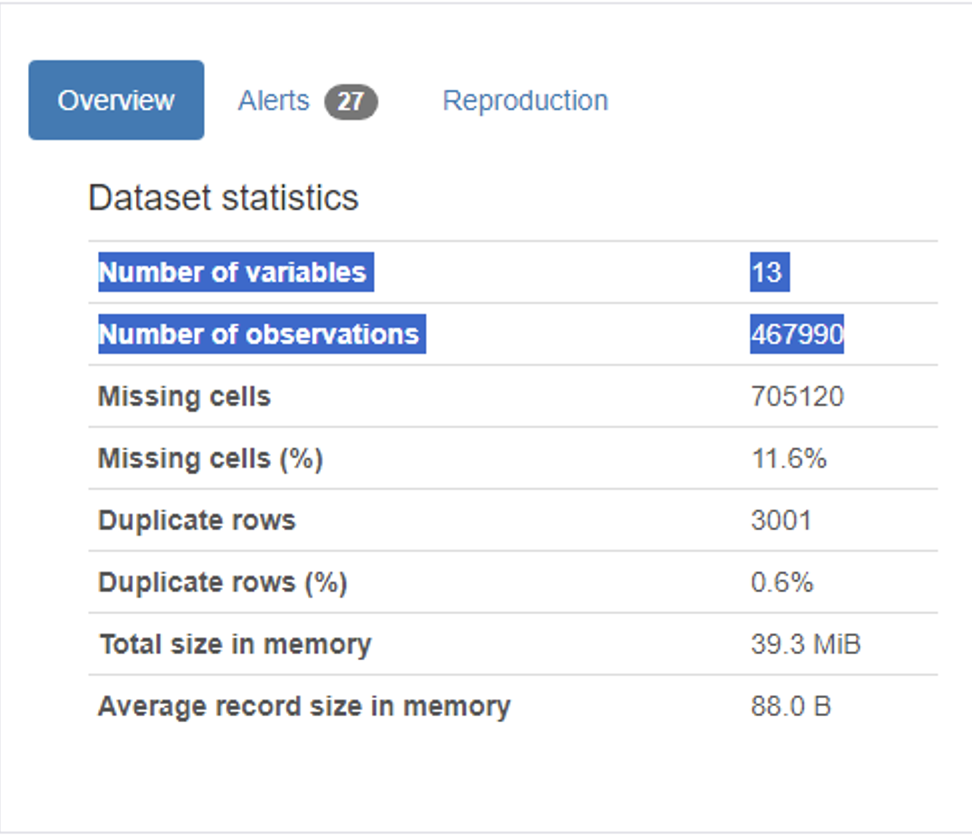

Se identifican los tipos de datos de las columnas existentes en la tabla VuelosCopia2

In [21]:
print("En la siguiente impresion se puede ver los tipos de datos de la tabla extraida")
for field in vuelos_copia.schema.fields:
    print(field.name +" , "+str(field.dataType))

En la siguiente impresion se puede ver los tipos de datos de la tabla extraida
ano , IntegerType
mes , StringType
origen , StringType
destino , StringType
tipo_equipo , StringType
tipo_vuelo , StringType
trafico , StringType
empresa , StringType
vuelos , IntegerType
sillas , IntegerType
carga_ofrecida , DoubleType
pasajeros , IntegerType
carga_bordo , DoubleType


Se identifican cantidad de columnas por tipo de datos

In [23]:
Counter([col[1] for col in vuelos_copia.dtypes])

Counter({'int': 4, 'string': 7, 'double': 2})

Resumiendo la tabla vuelosCopia2 tiene un total de 13 columnas, de las cuales hay 4 de tipo int, 2 de tipo double y 7 de tipo string. Adicional a esto actualmente hay 467990  registros en esta tabla.
Esto se visualiza en el reporte de pandas, donde los tipos int y double son considerados numericos y los string categoricos.
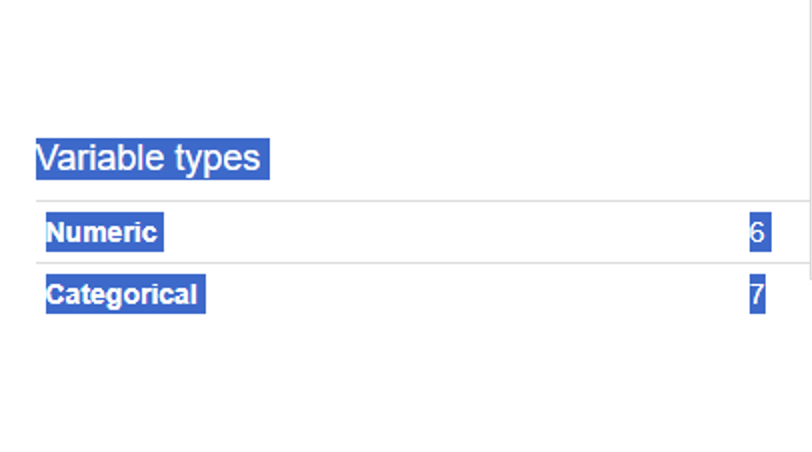


#### Significado de una fila
Tabla Vuelos Copia2
Para describir el significado de una fila en la tabla de vuelosCopia2, se mostraran algunos registros y se realizara un agrupamiento utilizando las columnas:

ano,mes: Identifica el periodo de tiempo en el cual se ofreceran los vuelos.

origen,destino: Identifica el origen y destino del trayecto o vuelo a realizar.

tipo_equipo: Identifica el tipo de avion disponible para el vuelo.

tipo_vuelo: Identifica el tipo de opreacion realizada

trafico,empresa: Identifica si el trayecto es nacional o internacional y la empresa que lo opera.

vuelos,sillas,carga_ofrecida,pasajeros,carga_bordo: identifica la capacidad mensual en numero de trayectos, sillas, carga disponible, sillas vendidas, carga transportada.


In [24]:
vuelos_copia.show(5)

+----+---+------+-------+-----------+----------+-------+--------+------+------+--------------+---------+-----------+
| ano|mes|origen|destino|tipo_equipo|tipo_vuelo|trafico| empresa|vuelos|sillas|carga_ofrecida|pasajeros|carga_bordo|
+----+---+------+-------+-----------+----------+-------+--------+------+------+--------------+---------+-----------+
|2004|  1|   bog|    mia|       B752|         R|      I|AMERICAN|     0|     0|           0.0|        0|        0.0|
|2004|  7|   bog|    mia|       B752|         R|      I|AMERICAN|    62| 11656|      327236.0|     7864|   118443.0|
|2004|  9|   bog|    mia|       B752|         R|      I|AMERICAN|    32|  6016|      168896.0|     4283|    73896.0|
|2004|  3|   bog|    mia|       B763|         R|      I|AMERICAN|    31|  6572|      351540.0|     3473|   203724.0|
|2004|  7|   bog|    mia|       B763|         R|      I|AMERICAN|    31|  6572|      351540.0|     4994|   219965.0|
+----+---+------+-------+-----------+----------+-------+--------

Ejemplo de datos mostrados en Pandas
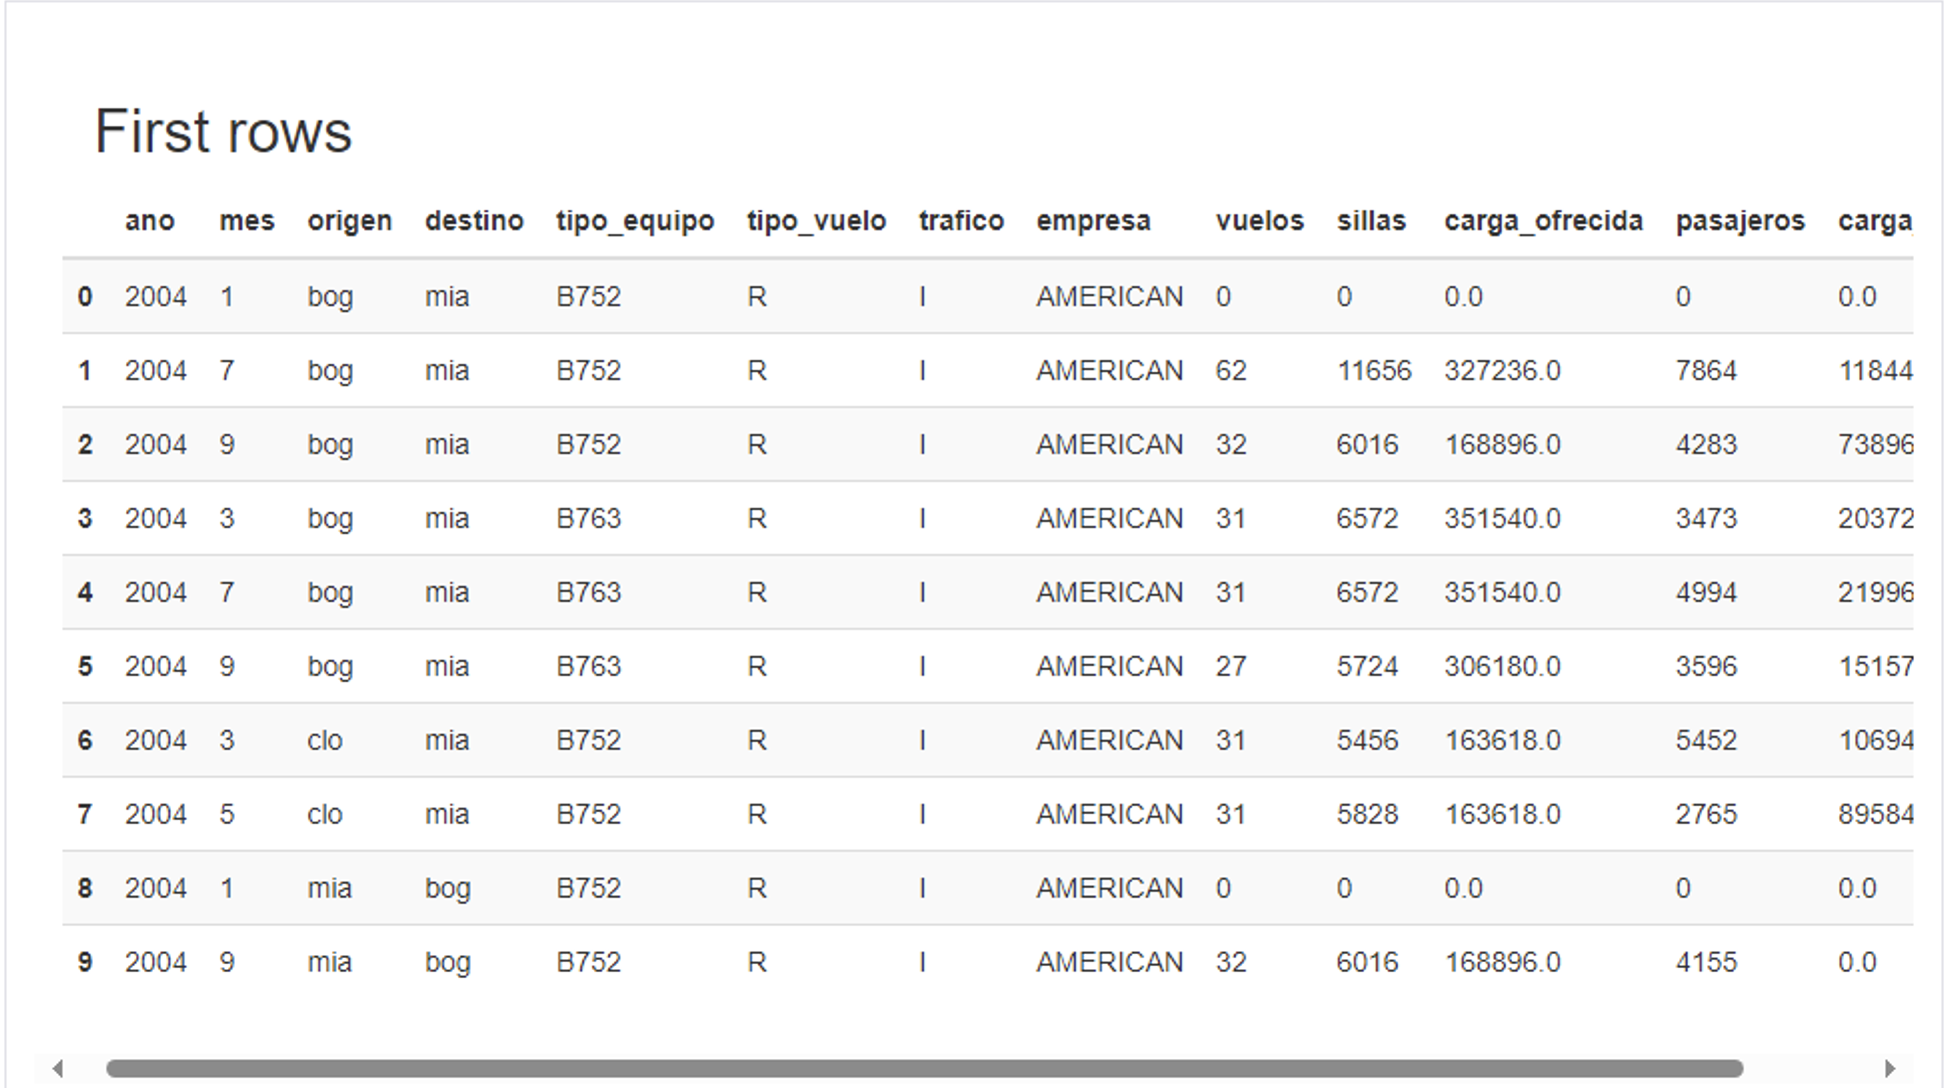

#### Descripción de columnas

In [30]:
vuelos_copia.groupby("ano").count().orderBy("ano", ascending=False).show(20)

+----+-----+
| ano|count|
+----+-----+
|2014|45389|
|2013|46561|
|2012|43324|
|2011|40525|
|2010|37196|
|2009|33156|
|2008|42530|
|2007|47501|
|2006|48097|
|2005|44842|
|2004|38869|
+----+-----+



La variable año cuenta con 11 valores distisntos donde el año mayor es 2014 y el menor es 2004, esto se puede verificar en pandas.
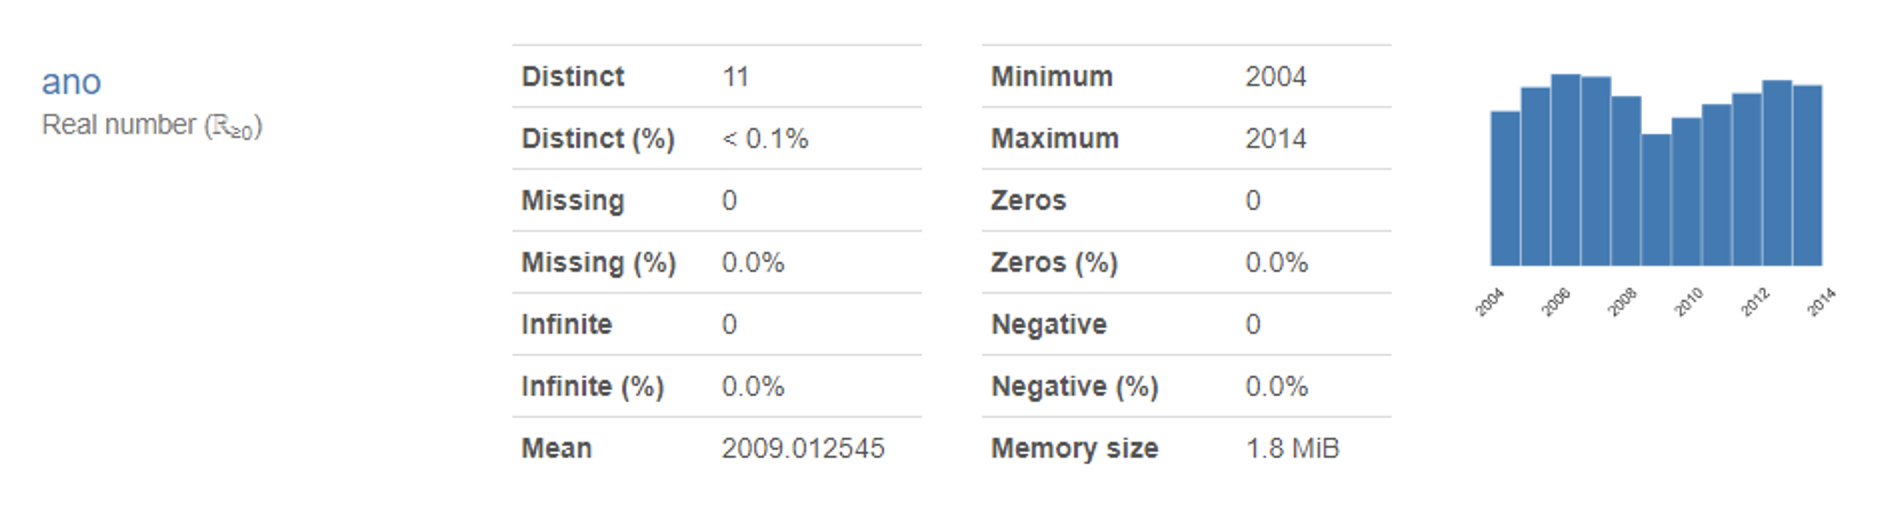

In [32]:
vuelos_copia.groupby("mes").count().orderBy("mes", ascending=False).show(30)

+---+-----+
|mes|count|
+---+-----+
|Sep|18999|
|Otc|20388|
|Nov|19168|
|May|19504|
|Mar|19941|
|Jun|19633|
|Jul|19165|
|Feb|19175|
|Ene|18887|
|Dic|20775|
|Ago|19620|
|Abr|19323|
|  9|19109|
|  8|19286|
|  7|19311|
|  6|19472|
|  5|19452|
|  4|19115|
|  3|20059|
|  2|18896|
| 12|20951|
| 11|18906|
| 10|20112|
|  1|18743|
+---+-----+



Podemos ver que la variable mes tiene 24 valores distintos, de estos valores podemos ver que todos representan el mismo mes pero no mantienen el mismo tipo de dato por lo cual se debe realizar  una estandarizacion de este campo, esto lo podemos corrroborar con la grafica de pandas.

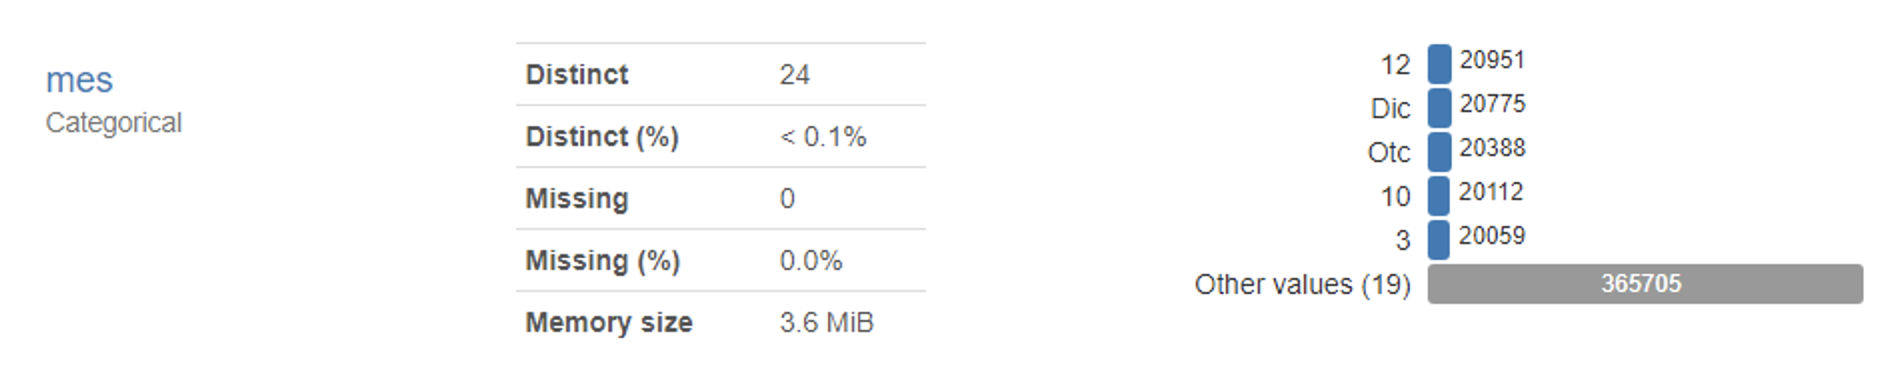

In [39]:
vuelos_copia.groupby("origen").count().orderBy("count", ascending=False).show(5)

+------+------+
|origen| count|
+------+------+
|  null|352549|
|   bog| 17979|
|   vvc|  7686|
|   eoh|  4865|
|   eyp|  4282|
+------+------+
only showing top 5 rows



In [36]:
vuelos_copia.groupby("origen").count().orderBy("origen", ascending=False).count()

755

Como podemos observar la columna origen tiene un rango de informacion muy variada, sin embargo tenemos 755 datos diferentes e incluye filas vacias, origen mas comun es bog, esto lo podemos corroborar con la visualizacion en el reporte de pandas.


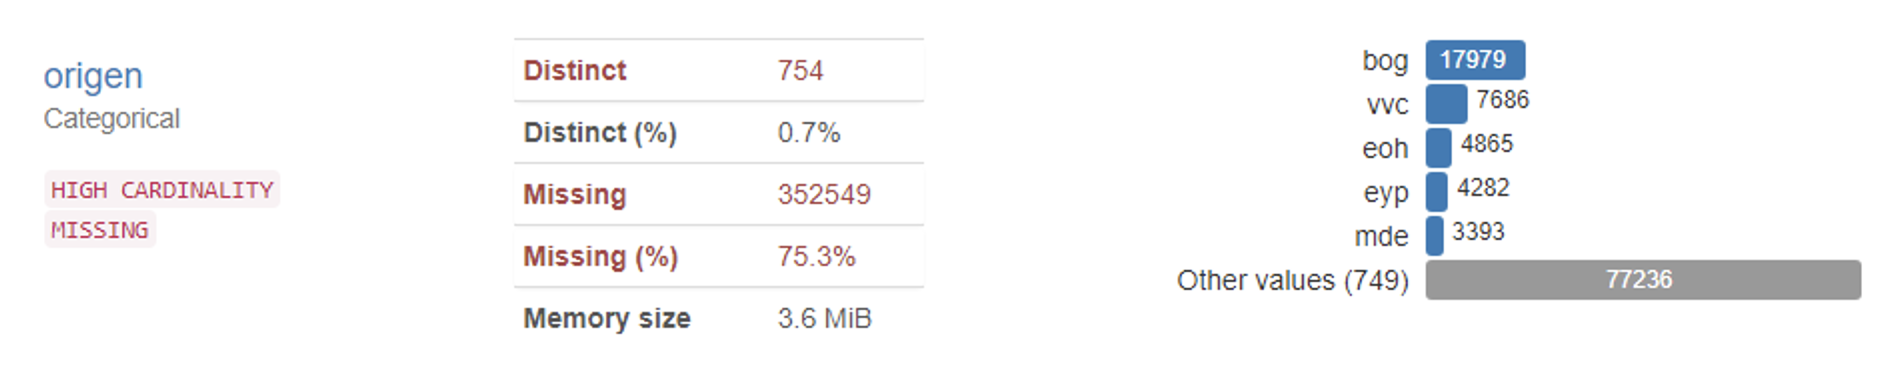

In [40]:
vuelos_copia.groupby("destino").count().orderBy("count", ascending=False).show(5)

+-------+------+
|destino| count|
+-------+------+
|   null|352549|
|    bog| 18368|
|    vvc|  7302|
|    eoh|  4942|
|    eyp|  4214|
+-------+------+
only showing top 5 rows



In [41]:
vuelos_copia.groupby("destino").count().orderBy("destino", ascending=False).count()

789

Como podemos observar la columna destino tiene un rango de informacion muy variada, sin embargo tenemos 789 datos diferentes e incluye filas vacias, destino mas comun es bog, esto lo podemos corroborar con la visualizacion en el reporte de pandas.

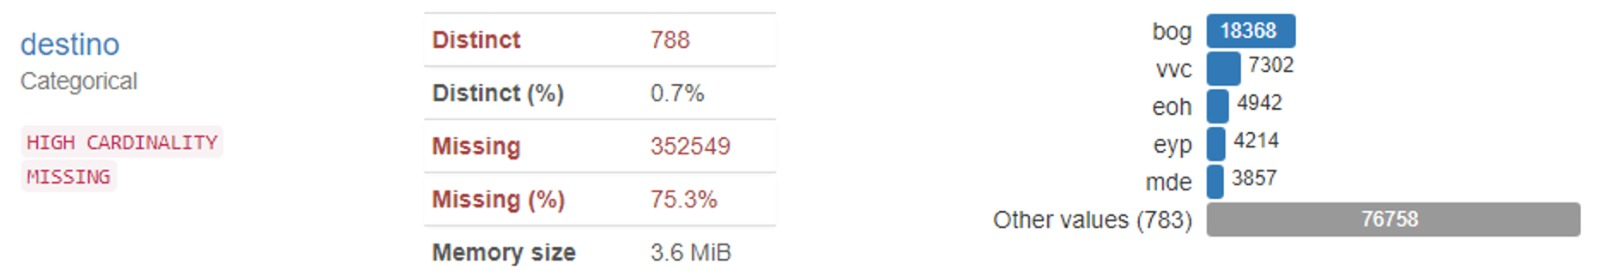

In [43]:
vuelos_copia.groupby("tipo_equipo").count().orderBy("count", ascending=False).show(10)

+-----------+-----+
|tipo_equipo|count|
+-----------+-----+
|       C206|52454|
|       C172|40385|
|       C182|24280|
|       PA34|22802|
|       B190|20842|
|       L410|20015|
|        DC3|14132|
|       JS32|12648|
|       A320|11081|
|       D328| 9747|
+-----------+-----+
only showing top 10 rows



In [44]:
vuelos_copia.groupby("tipo_equipo").count().orderBy("tipo_equipo", ascending=False).count()

196

Como podemos observar la columna tipo_equipo tiene un rango de informacion muy variada respecto a los modelos de aviones, sin embargo tenemos 196 datos diferentes y no tenemos filas vacias, esto lo podemos corroborar con la visualizacion en el reporte de pandas.

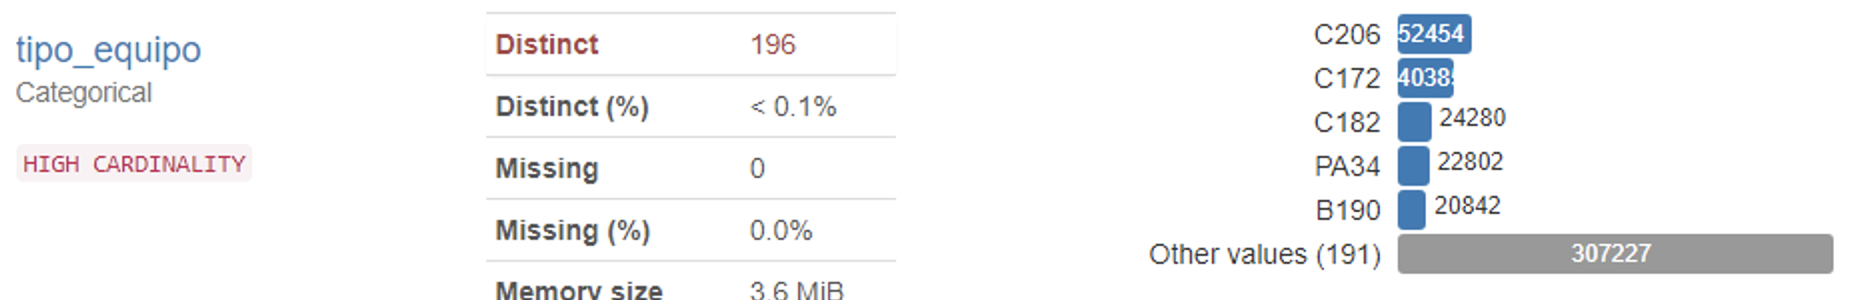

In [45]:
vuelos_copia.groupby("tipo_vuelo").count().orderBy("count", ascending=False).show(10)

+----------+------+
|tipo_vuelo| count|
+----------+------+
|         T|278478|
|         R|177175|
|         C|  7072|
|         A|  5265|
+----------+------+



Como podemos observar la columna tipo_vuelo tiene un rango de informacion estatica,que es la esperada a los datos compartidos por el negocio en el diccionario de datos,  esto lo podemos corroborar con la visualizacion en el reporte de pandas.

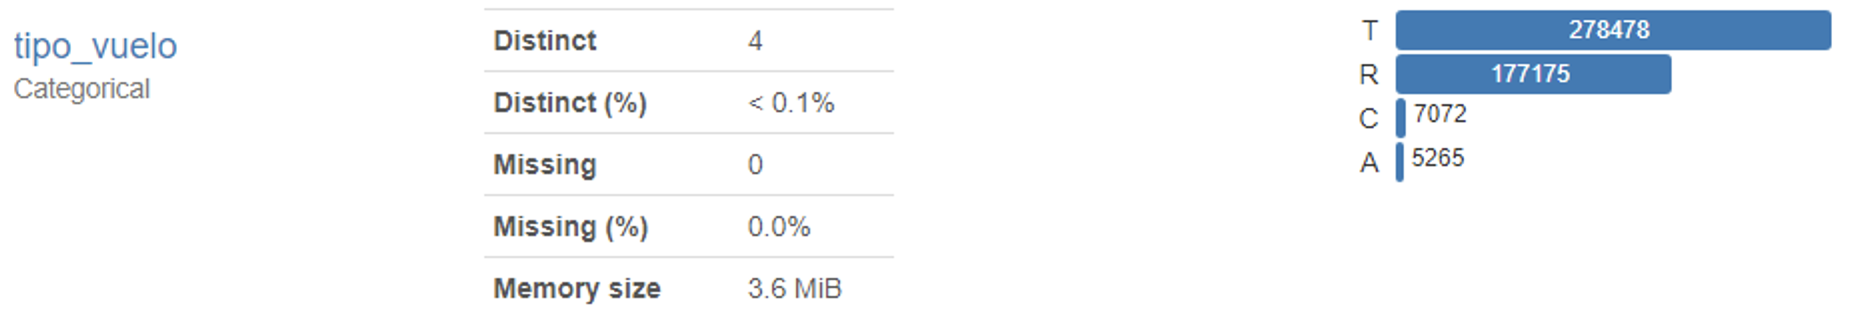

In [46]:
vuelos_copia.groupby("trafico").count().orderBy("count", ascending=False).show(10)

+-------+------+
|trafico| count|
+-------+------+
|      N|394889|
|      I| 65238|
|      E|  7863|
+-------+------+



Como podemos observar la columna trafico tiene un rango de informacion estatica,que es la esperada a los datos compartidos por el negocio en el diccionario de datos, esto lo podemos corroborar con la visualizacion en el reporte de pandas.

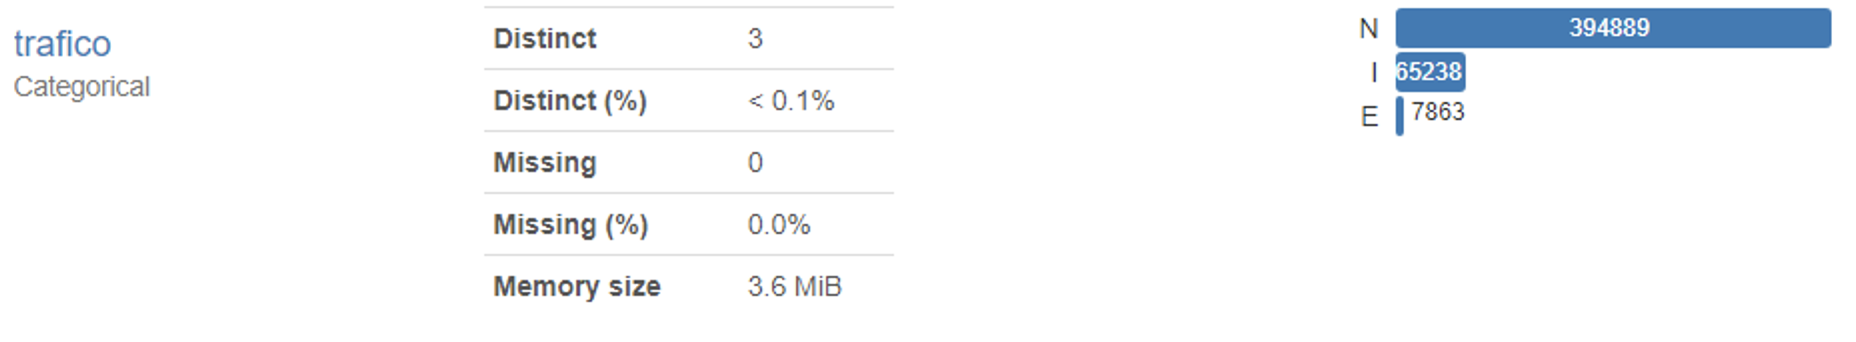

In [47]:
vuelos_copia.groupby("empresa").count().orderBy("count", ascending=False).show(10)

+--------------------+-----+
|             empresa|count|
+--------------------+-----+
|             AVIANCA|35167|
|         SEARCA S.A.|34999|
|SERVICIO AEREO A ...|23837|
|         ALPES S.A.S|21079|
|               AIRES|18814|
|                SAER|16154|
|AEROLINEAS LLANER...|15288|
|          AERO APOYO|14113|
|       AEROREPUBLICA|13402|
|       AEROCOL S.A.S|12260|
+--------------------+-----+
only showing top 10 rows



In [48]:
vuelos_copia.groupby("empresa").count().orderBy("empresa", ascending=False).count()

188

Como podemos observar la columna empresa tiene un rango de informacion muy variada, podemos ver que se tienen 188 datos distintos, esto lo podemos corroborar con la visualizacion en el reporte de pandas.

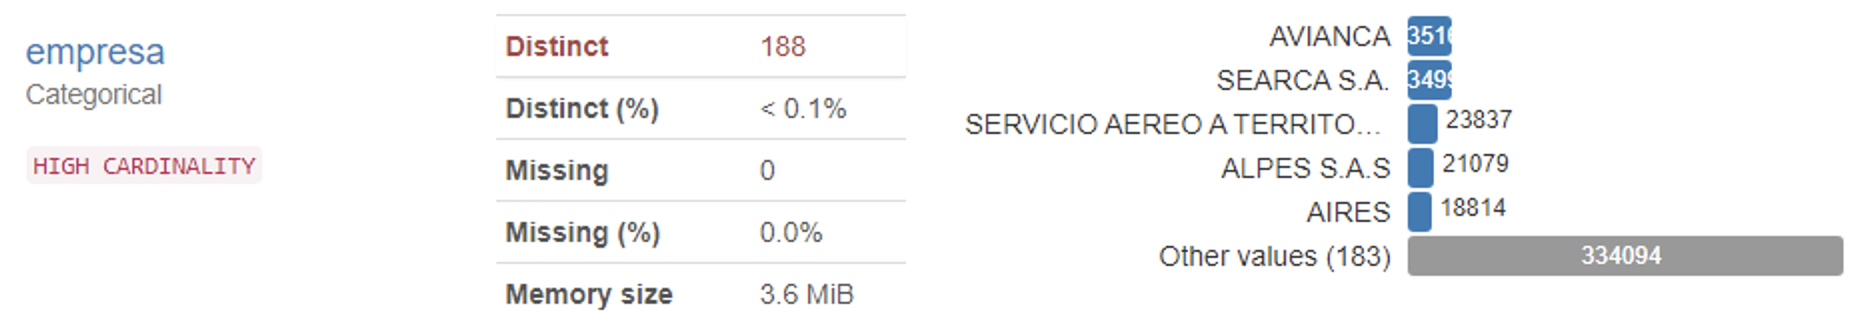

In [49]:
vuelos_copia.groupby("vuelos").count().orderBy("count", ascending=False).show(10)

+------+------+
|vuelos| count|
+------+------+
|     1|190271|
|     2| 63621|
|     3| 32704|
|     4| 23776|
|     5| 15986|
|     6| 11200|
|     7|  9024|
|     8|  8732|
|     9|  7980|
|    13|  6168|
+------+------+
only showing top 10 rows



In [50]:
vuelos_copia.groupby("vuelos").count().orderBy("vuelos", ascending=False).count()

518

Como podemos observar la columna vuelos tiene un rango numerico amplio, podemos ver que se tienen 518 datos distintos, esto lo podemos corroborar con la visualizacion en el reporte de pandas.

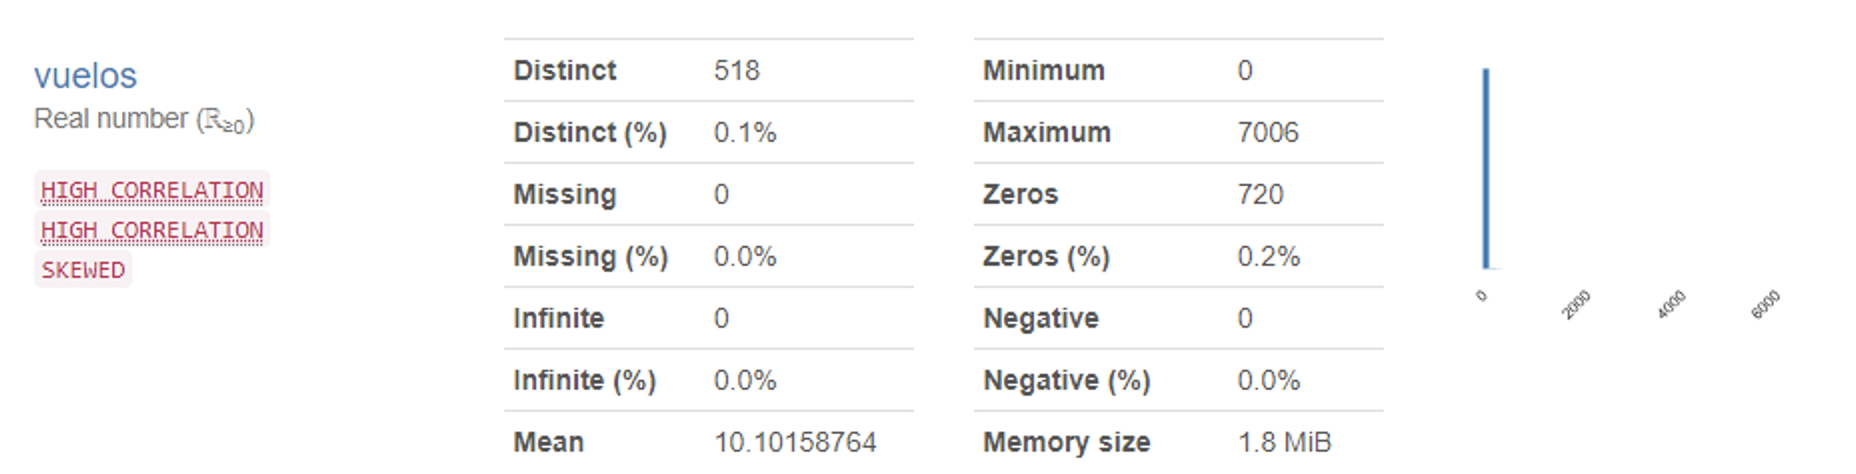

Las variables sillas, Carga ofrecida, pasajeros, carga a bordo cuentan con valores numericos que pueden tomar culquier valor.

### Análisis descriptivo

In [54]:
vuelos_copia.summary().show()

+-------+------------------+------------------+------+-------+------------------+----------+-------+------------------+------------------+-----------------+-----------------+------------------+------------------+
|summary|               ano|               mes|origen|destino|       tipo_equipo|tipo_vuelo|trafico|           empresa|            vuelos|           sillas|   carga_ofrecida|         pasajeros|       carga_bordo|
+-------+------------------+------------------+------+-------+------------------+----------+-------+------------------+------------------+-----------------+-----------------+------------------+------------------+
|  count|            467990|            467990|115441| 115441|            467990|    467990| 467990|            467990|            467990|           467990|           467987|            467990|            467971|
|   mean|2009.0125451398535|6.5515397665929775|  null|   null| 627.5512585591667|      null|   null|              null|10.101587640761554|723.759932

Como se menciono anteriormente las columnas vuelos, sillas, carga, ofrecida, pasajeros carga a bordo son variables numericas que no tienen un valor definido, podemos ver que los rangos numericos van desde 0 hasta un valor muy grande como veremos a continuacion.

Por otro lado tambien vemos que las variables categoricas, tienen datos estatiticos algunos muy definidos como vimos en los analisis iniciales y muy acorde a lo indicado por el negocio en el diccionario de datos.

{'whiskers': [<matplotlib.lines.Line2D at 0x1ed0b987448>,
 'caps': [<matplotlib.lines.Line2D at 0x1ed0e7af308>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ed107236c8>],
 'medians': [<matplotlib.lines.Line2D at 0x1ed0e7af108>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ed0e7aff08>],
 'means': []}

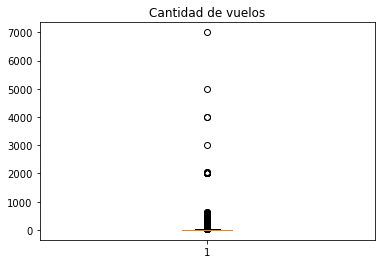

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('Cantidad de vuelos')
ax1.boxplot(np.array(vuelos_copia.select('vuelos').collect()))

Podemos ver que la variable vuelos tiene un rango que va de 0 a mas de 7000.

{'whiskers': [<matplotlib.lines.Line2D at 0x1ed0f20cc08>,
 'caps': [<matplotlib.lines.Line2D at 0x1ed0f186e08>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ed0fc16688>],
 'medians': [<matplotlib.lines.Line2D at 0x1ed7d084dc8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ed0c105f08>],
 'means': []}

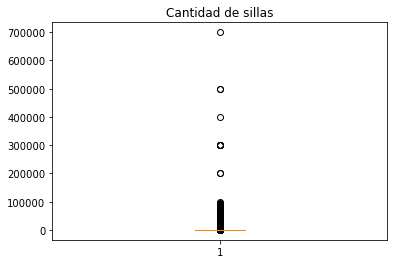

In [56]:
fig1, ax1 = plt.subplots()
ax1.set_title('Cantidad de sillas')
ax1.boxplot(np.array(vuelos_copia.select('sillas').collect()))

Podemos ver que la variable vuelos tiene un rango que va de 0 a mas de 700.000.
Es importante confirmar con el negocio si este rango es correcto

{'whiskers': [<matplotlib.lines.Line2D at 0x1ed0e8db508>,
 'caps': [<matplotlib.lines.Line2D at 0x1ed0c875b48>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ed7d5e4808>],
 'medians': [<matplotlib.lines.Line2D at 0x1ed0c886888>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ed0c886d08>],
 'means': []}

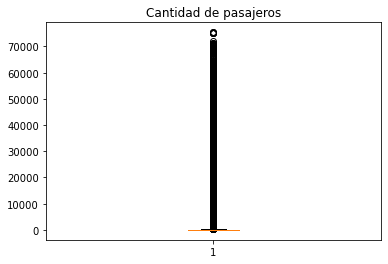

In [58]:
fig1, ax1 = plt.subplots()
ax1.set_title('Cantidad de pasajeros')
ax1.boxplot(np.array(vuelos_copia.select('pasajeros').collect()))

Podemos ver que la variable pasajeros tiene un rango que va de 0 a mas de 70.000. Es importante confirmar con el negocio si este rango es correcto

## Analisis de Calidad de los Datos
### Tabla VuelosCopia2
#### Unicidad y validez

In [59]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        vacios = df.filter(df[c].isNull()).count()
        if vacios!=0:
            print('número de vacíos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
    return resultados

def cardinalidad(df):
    resultado = {}
    for c in df.columns:
        cardinalidad = df.select(col(c)).distinct().count()
        if cardinalidad>=df.count()*0.5:
            resultado[c] = cardinalidad
    return resultado

In [60]:
print('detalles de vuelos: ')
columnas_vacias_ordenes = contar_vacios(vuelos_copia)


detalles de vuelos: 
número de vacíos para columna origen: 352549
número de vacíos para columna destino: 352549
número de vacíos para columna carga_ofrecida: 3
número de vacíos para columna carga_bordo: 19


Como podemos observar la columna origen cuenta con 352.549 registros vacios, destino cuenta con 352,549 registros vacios , carga ofrecida cuenta con 3 registros vacios , carga a bordo cuenta con 19 registros vacios.

esto se ve en el grafico de pandas.
##### Origen
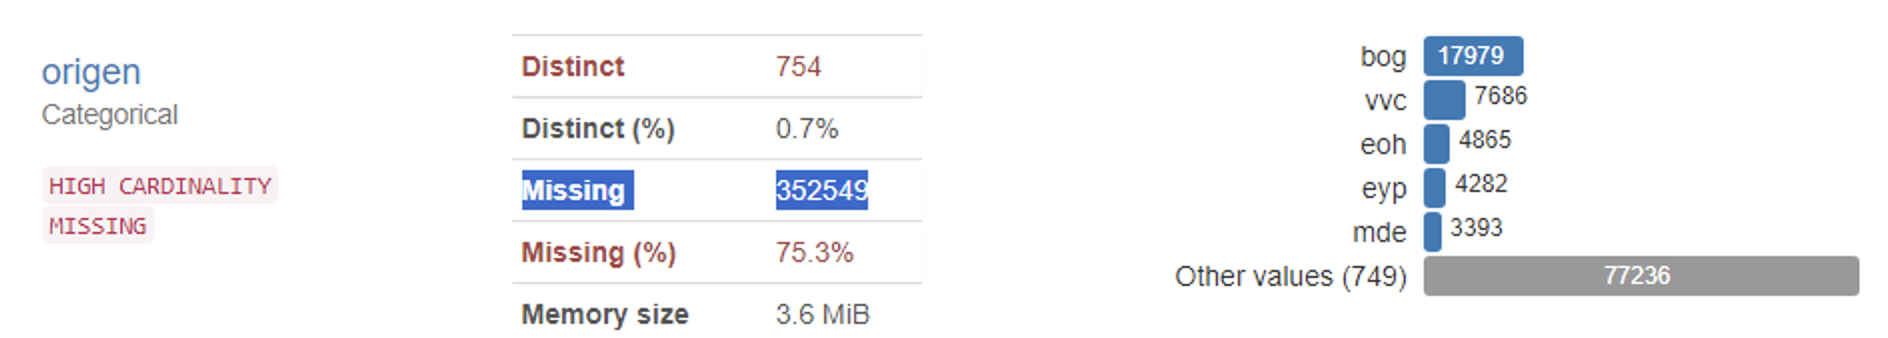
##### Destino
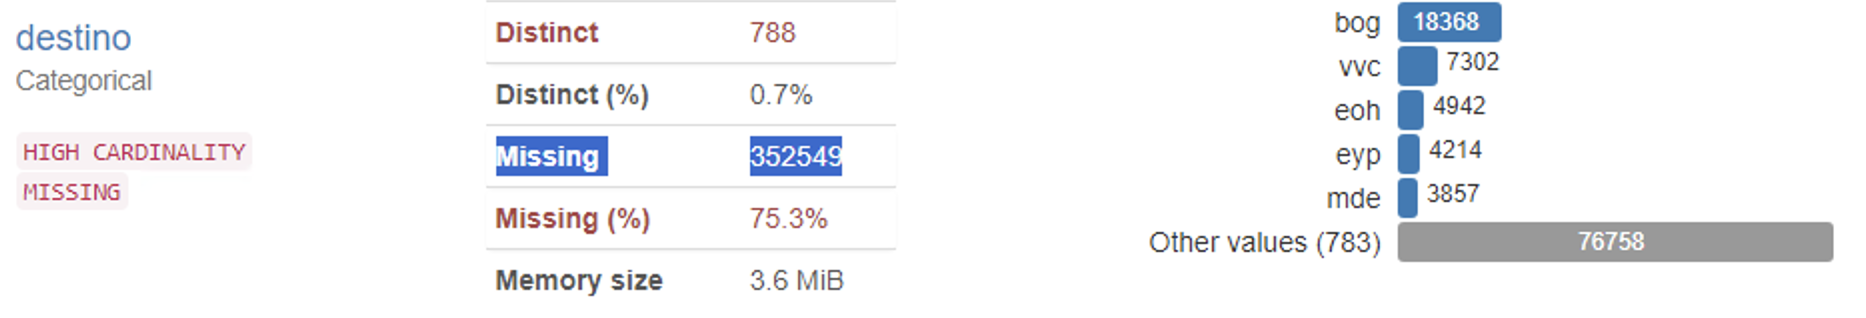
##### carga_ofrecida
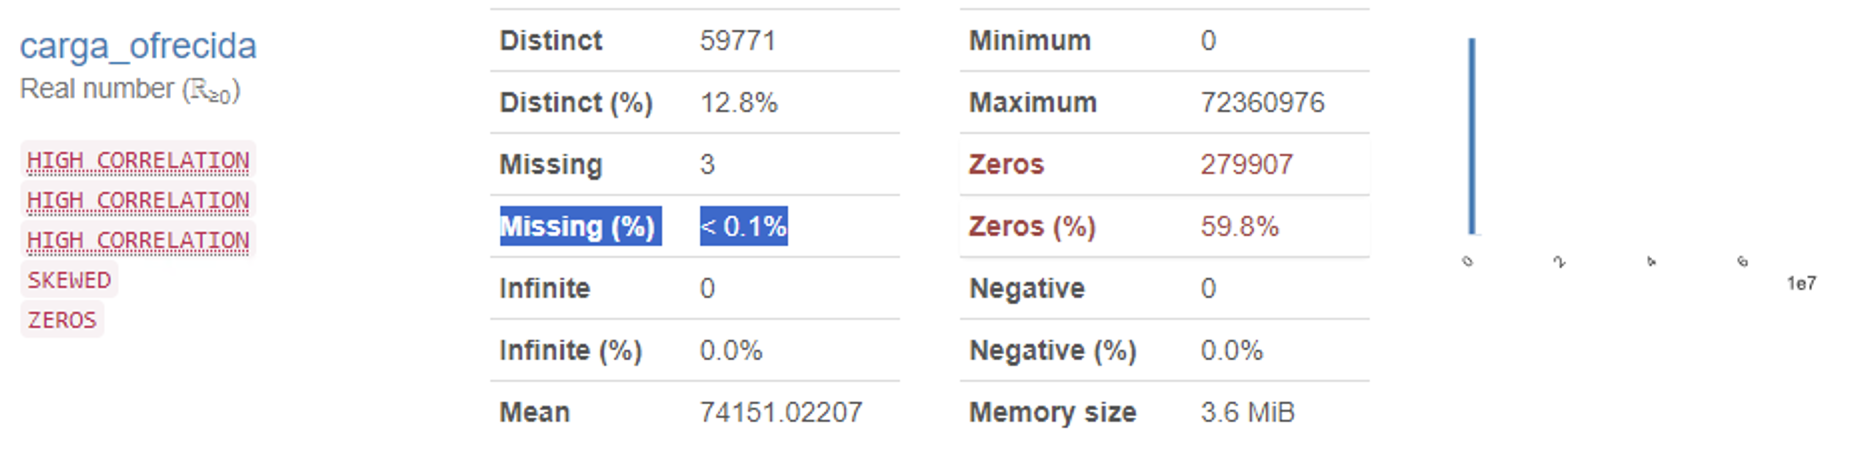
##### carga_bordo
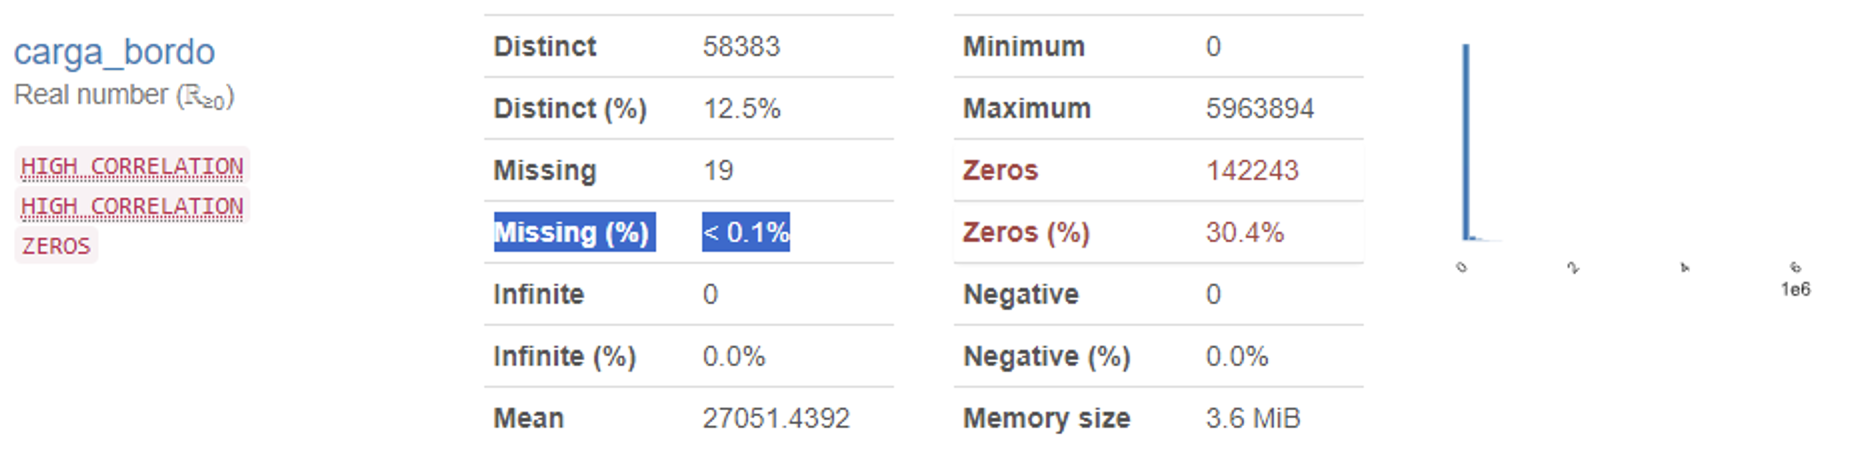

Dada la cantidad de datos faltantes en las columnas  origen - destino y dado que el valor es el mismo debemos consultar al negocio si los datos son correctos o si existe algun error en la informacion entregada y estos registros no tiene validez para el negocio.

### Consistencia
Tabla vuelos_copia
A nivel de consistencia para la tabla vuelosCopia2 se validara que la información consignada renga relacion, con esto se logra identificar que existe 51678 registros duplicados.

In [68]:
vuelos_copia_tmp = vuelos_copia
vuelos_copia_tmp = vuelos_copia_tmp.drop_duplicates()
vuelos_copia_tmp.count()
print("Total     | sin Duplicados   ")
print(f"{vuelos_copia.count()}   ", f"| {vuelos_copia_tmp.count()} ")
print("Diferencia=",vuelos_copia.count()-vuelos_copia_tmp.count())

Total     | sin Duplicados   
467990    | 416312 
Diferencia= 51678


#### Conclusión del entendimiento de datos
Conclusiones generales:
* En la Tabla Vuelos Copia2 tenemos informacion de los vuelos realizados por las diferentes aerolineas en un rango de timpo desde el 2004 al 2014, alli podemos ver los trayectos mas comunes, cantidad de sillas disponibles vs cantidad de sillas vendidas, cantidad de carga disponible vs cantidad de carga transportada.
* Una fila en  Vuelos Copia2 representa la cantidad de vuelos realizados por una compañia, en un trayecto especifico y un modelo de avion espeficico, en una rango de tiempo determinado normalmente de 1 mes.
* La informacion suministrada por el cliente, tiene algunas falencias en cuanto a la información del trayecto lo que genera que tanto el origen como el destino tengan la misma cantidad de registros nulos o vacios.

Conclusiones de reglas de negocio:

* El negocio indica "Hay información de 605.448 vuelos entre 2004 y 2018 ", esta información no es correcta por dos razones, los datos existentes tiene un rango de fechas desde el 2004 hasta el 2014 y la cantidad de registros disponibles en total es de 467990 lo cual nos hace sospechar que falta información o el cliente nos facilito una data incompleta.
* Adicional al comentario anterior tenemos identificados 51618 registros que parecen estar duplicados lo que tambien nos hace pensar que la cantidad disponible de información real que tiene el cliente no es la indicada.
* Dada la cantidad de registros vacios en las columnas Origen y Destino, solo tenemos 115441 registros con información completa que pueda ser analizada.

Conclusiones de calidad:
* Tenemos 352549 registros vacios para la columna Origen, dado el total de 467990 solo tenemos disponible informacion del origen del vuelo para 115441.
* Tenemos 352549 registros vacios para la columna Origen, dado el total de 467990 solo tenemos disponible informacion del destino del vuelo para 115441.
* La columna carga Ofrecida cuenta con 3 registros vacios.
* La Columna Carga a bordo cuenta con 19 registros vacios.
* La columna Tipo de Vuelo contiene los siguientes 4 valores  (T| R| C| A), es importante que se documente con el clientee que significan estos valores ya que el diccionario de datos solo tiene los valores de ejemplo R -T.
* La columna trafico contiene los sigueintes  3 valores (N| I| E), s importante que se documente con el clientee que significan estos valores ya que el diccionario de datos solo tiene los valores de ejemplo Internacional - Nacional, lo cual no es claro si la siglas hacen referencia a estos valores o a otro valor.
* La columna Mes tiene valores que representan el Mes tanto en texto xomo en formato Numerico, es importante realizar una estandarizacion de estos para facilitar el entendimiento.
* Tenemos registros que contienen 0 sillas, 0 vuelos, 0 Pasajeros, O Carga, esto puede ser un error de los datos, o un registro que se se pueda eliminar ya que no representaria informacion util para el negocio.



### Lista de preguntas o comentarios realizados a la organización

* Para la variable de Vuelos, tenemos rangos que pueden ir desde 0 hasta 700,000 es correcto que podamos hacer tantos recorridos en un solo mes?, esto se debe a que la empresa dispone de varias aviones con este mismo modelo y logra alcanzar esta cifra d e vuelos?, sin embargo parece ser que es un error de digitación de la información ya que realizar este numero de vuelos con el mismo modelo de avion y en el mismo trayecto durante un solo mes parece no ser algo normal.
* La información se encuentra completa? se esperaba tener 605448 registros de vuelos entre el 2004 y 2018 y no contamos con esta información dado que existen datos vacios y el numero de registros en la tabla no es el indicado o no esta en el rango de años indicado.
* Que significan los valores (T| R| C| A) para la columna tipo Vuelo.
* Que significan los valores (N| I| E) para la columna Trafico.
* Si un registro cuenta con 0 sillas, 0 vuelos, 0 pasajeros, 0 carga no es valido?
* si un registro no cuenta con origen y detisno es valido?